In [20]:
# ================================================
# Titanic: DT vs RF (preprocess, tune, CV, plot)
# ================================================
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# -----------------------------
# 1) Load data
# -----------------------------
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# Keep PassengerId for submission later
test_passenger_ids = test["PassengerId"].copy()

# -----------------------------
# Feature engineering
# -----------------------------
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Title from Name
    out["PersonTitle"] = out["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    rare = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
    out["PersonTitle"] = out["PersonTitle"].replace(rare, "Rare")
    out["PersonTitle"] = out["PersonTitle"].replace({"Mlle":"Miss","Ms":"Miss","Mme":"Mrs"})

    # Family size features
    out["RelativesCount"] = out["SibSp"] + out["Parch"] + 1
    out["SoloTraveler"]   = (out["RelativesCount"] == 1).astype(int)

    # Combo features
    out["AgeClassCombo"] = out["Age"] * out["Pclass"]

    # Cabin section (first letter)
    out["CabinSection"] = out["Cabin"].str[0].fillna("Missing")

    # Per-person fare
    out["IndividualFare"] = out["Fare"] / out["RelativesCount"]

    # Drop high-cardinality or IDs we shouldn't use
    drop_cols = ["PassengerId","Name","Ticket","Cabin"]
    for c in drop_cols:
        if c in out.columns:
            out = out.drop(columns=c)

    return out

train_fe = add_features(train)
test_fe  = add_features(test)

# Split features/target
X = train_fe.drop("Survived", axis=1)
y = train_fe["Survived"]

# -----------------------------
# 1) Preprocess (numeric + categorical)
# -----------------------------
num_cols = ['Age','Fare','SibSp','Parch','RelativesCount','AgeClassCombo','IndividualFare']
cat_cols = ['Pclass','Sex','Embarked','PersonTitle','CabinSection','SoloTraveler']

num_proc = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_proc = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_proc, num_cols),
    ('cat', cat_proc, cat_cols)
])

Best Decision Tree params: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Best Decision Tree (CV) accuracy: 0.8428


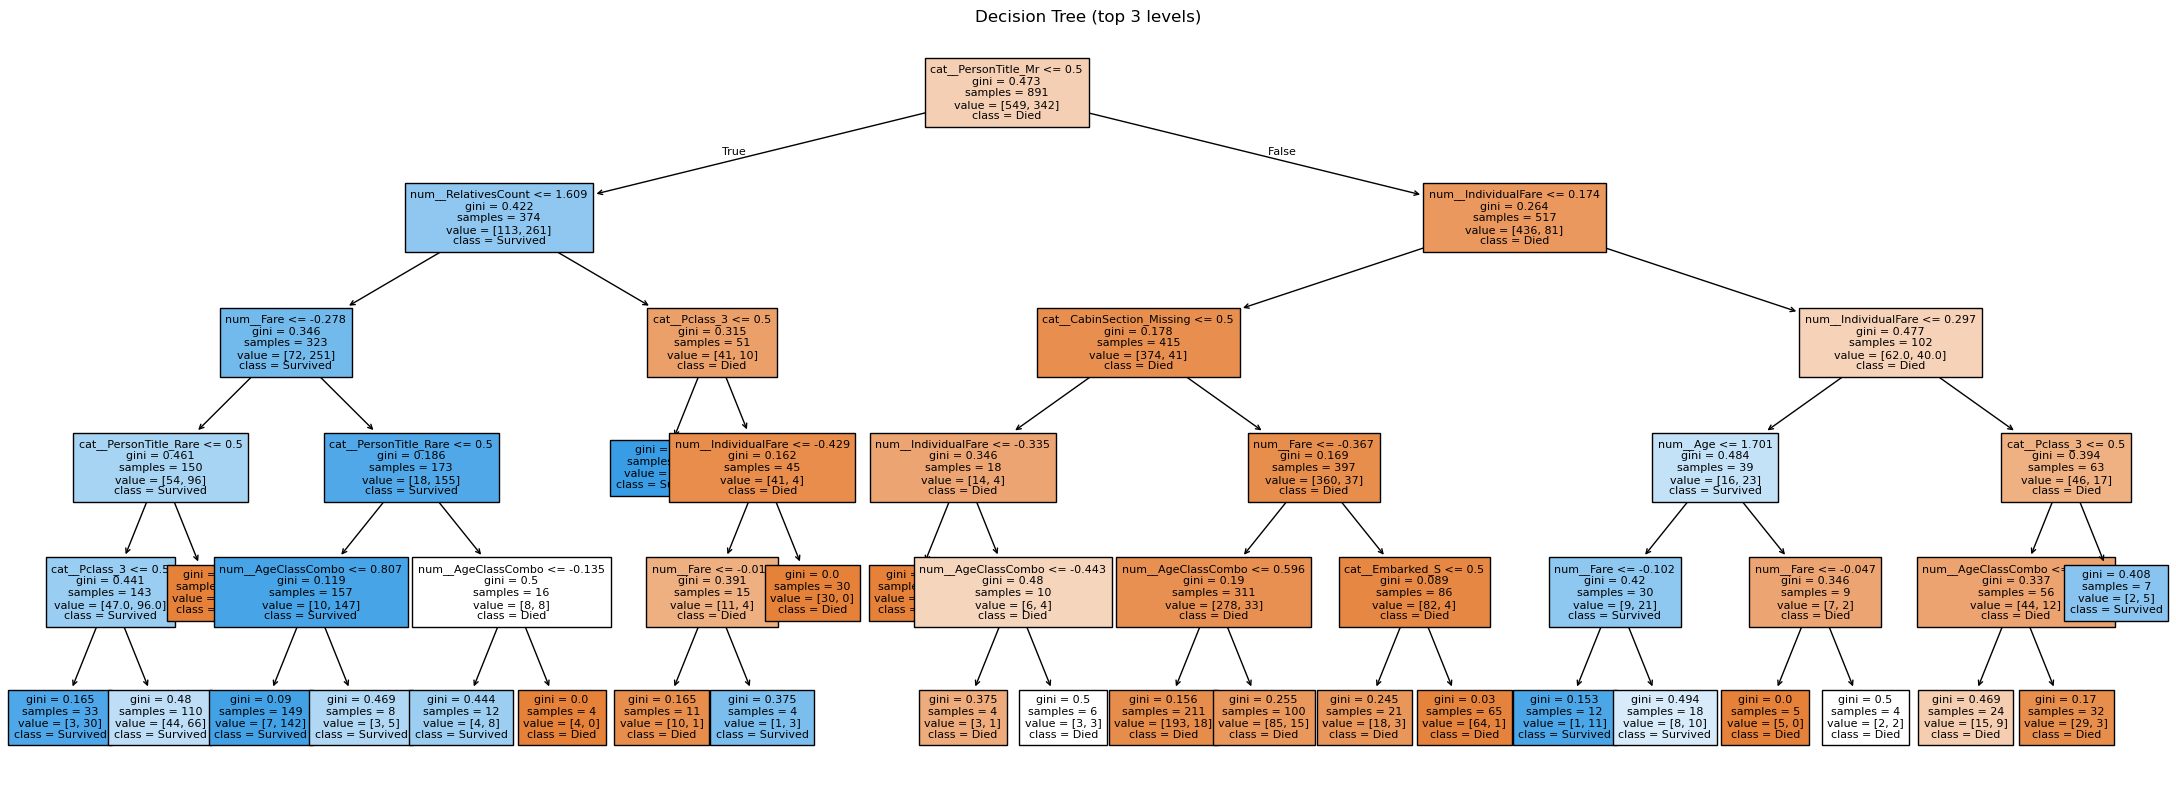

In [11]:
# Common CV splitter
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================================
# 2) Fine-tune Decision Tree (with plot)
# ==========================================================
dt_pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

dt_param_grid = {
    'clf__criterion': ['gini','entropy','log_loss'],
    'clf__max_depth': [3,4,5,6,8,10,None],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4]
}

dt_grid = GridSearchCV(
    dt_pipe,
    dt_param_grid,
    scoring='accuracy',
    cv=cv5,
    n_jobs=-1,
    refit=True
)
dt_grid.fit(X, y)

print("Best Decision Tree params:", dt_grid.best_params_)
print("Best Decision Tree (CV) accuracy: {:.4f}".format(dt_grid.best_score_))

# Extract the fitted DecisionTreeClassifier from the pipeline
best_dt_clf = dt_grid.best_estimator_.named_steps['clf']

# Make a feature name list (from the preprocessor)
feature_names = dt_grid.best_estimator_.named_steps['prep'].get_feature_names_out()

# Plot the top 3 levels of the best DT
plt.figure(figsize=(22, 8))
plot_tree(
    best_dt_clf,
    feature_names=feature_names,
    class_names=['Died','Survived'],
    filled=True,
    max_depth=None,
    fontsize=8
)
plt.title("Decision Tree (top 3 levels)")
plt.tight_layout()
plt.savefig("decision_tree_top3.png", dpi=200)
plt.show()

In [13]:
# ==========================================================
# 3) 5-fold CV on the fine-tuned Decision Tree (refit=True already)
#    (We re-evaluate to print per-fold scores clearly)
# ==========================================================
dt_cv_scores = cross_val_score(
    dt_grid.best_estimator_,
    X, y,
    scoring='accuracy',
    cv=cv5,
    n_jobs=-1
)
print("Decision Tree 5-fold accuracies:", np.round(dt_cv_scores, 4))
print("Decision Tree mean accuracy    : {:.4f}".format(dt_cv_scores.mean()))

Decision Tree 5-fold accuracies: [0.8715 0.8483 0.8371 0.8202 0.8371]
Decision Tree mean accuracy    : 0.8428


In [18]:
# ==========================================================
# 4) Fine-tune Random Forest + 5-fold CV
# ==========================================================
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__criterion': ['gini','entropy','log_loss'],
    'clf__max_depth': [6,10,None],
    'clf__min_samples_split': [2,5],
    'clf__min_samples_leaf': [1,2,4],
    'clf__max_features': ['sqrt','log2', None]
}

rf_grid = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    scoring='accuracy',
    cv=cv5,
    n_jobs=-1,
    refit=True
)
rf_grid.fit(X, y)

print("\nBest Random Forest params:", rf_grid.best_params_)
print("Best Random Forest (CV) accuracy: {:.4f}".format(rf_grid.best_score_))

rf_cv_scores = cross_val_score(
    rf_grid.best_estimator_,
    X, y,
    scoring='accuracy',
    cv=cv5,
    n_jobs=-1
)
print("Random Forest 5-fold accuracies:", np.round(rf_cv_scores, 4))
print("Random Forest mean accuracy    : {:.4f}".format(rf_cv_scores.mean()))

# ==========================================================
# 5) Comparison & Conclusion
# ==========================================================
print("\n=== Comparison ===")
print("Decision Tree  mean CV acc :", round(dt_cv_scores.mean(), 4))
print("Random Forest mean CV acc :", round(rf_cv_scores.mean(), 4))

if rf_cv_scores.mean() > dt_cv_scores.mean():
    print("Conclusion: ✅ Random Forest performs better (lower variance via ensembling).")
elif rf_cv_scores.mean() < dt_cv_scores.mean():
    print("Conclusion: ✅ Decision Tree performs better here (simpler boundary fits this data).")
else:
    print("Conclusion: ⚖️ Both perform similarly on 5-fold accuracy.")

# ==========================================================
# (Optional) Train best RF on all training data and create Kaggle predictions
# ==========================================================
# Fit best RF on full training set
rf_best = rf_grid.best_estimator_
rf_best.fit(X, y)

# Prepare test set (note: we engineered features in add_features already)
# We need to re-attach a few columns that were dropped before we called preprocessor
X_test = test_fe.copy()  # same columns as X (no Survived)

# Predict
test_pred = rf_best.predict(X_test)

# Save submission file
sub = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_pred.astype(int)
})
sub.to_csv("titanic_rf_submission.csv", index=False)
print("\nSaved Kaggle submission: titanic_rf_submission.csv")
print("Decision tree plot saved as: decision_tree_top3.png")



Best Random Forest params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}
Best Random Forest (CV) accuracy: 0.8485
Random Forest 5-fold accuracies: [0.8715 0.8427 0.8315 0.8427 0.8539]
Random Forest mean accuracy    : 0.8485

=== Comparison ===
Decision Tree  mean CV acc : 0.8428
Random Forest mean CV acc : 0.8485
Conclusion: ✅ Random Forest performs better (lower variance via ensembling).

Saved Kaggle submission: titanic_rf_submission.csv
Decision tree plot saved as: decision_tree_top3.png
